# Point Cloud QoE Models

## Joint Communication and Computational Resource Allocation for QoE-driven Point Cloud Video Streaming

In [2]:
def get_distance_weight(g, k, d):
    # p_g,k in equation (5)
    # input: tile k in GOF g, distance d from the viewer to the object
    # output: for simplicity: all tiles have the same distance as d.
    return 1/d


0.3333333333333333


In [ ]:
def get_quality_weight(n, N):
    # QT_g,k in equation (5)
    # input: tile k in GOF g
    # output: the ratio of # of points in the tile k (n) to the total # of points in FOV (N)
    return n/N

In [ ]:
def get_quality_contribution(g, k, d, r):
    # output: quality contribution of tile k in GOF g with quality r at distance d
    distance_weight = get_distance_weight(g, k, d)
    quality_weight = get_quality_weight(n, N)

    return distance_weight * r * quality_weight


In [ ]:
def get_qoe_score (M, R, G, d):
    sum_1 = 0
    sum_2 = 0
    for g in range(G):
        for k in range(M):
            r = 1
            sum_1 += get_quality_contribution(g, k, d, r)
            sum_2 += get_quality_contribution(g, k, d, r) * R/r

    return sum_1/sum_2
    

## Objective metrics for PC compression

In [4]:
import re
import matplotlib.pyplot as plt

In [5]:
def calculate_frame_psnr(file):
    psnr_y = []
    psnr_cb = []
    psnr_cr = []
    psnr_color = []
    psnr_geometry = []

    with open(file) as f:
        lines = f.readlines()

        for line in lines:
            value = line.split(":")
            if len(value) > 1:
                if "c[0],PSNRF" in line:
                    psnr_y.append(float(value[1]))
                    continue

                if "c[1],PSNRF" in line:
                    psnr_cb.append(float(value[1]))
                    continue

                if "c[2],PSNRF" in line:
                    psnr_cr.append(float(value[1]))
                    continue
                if "mseF,PSNR" in line:
                    psnr_geometry.append(float(value[1]))
    
    # psnr_avg = 0
    for y, cb, cr in zip(psnr_y, psnr_cb, psnr_cr):
        psnr_color.append((4*y +cb + cr)/6)
        # psnr_avg += (4*y +cb + cr)/6

    # print("PSNR: ", psnr_frame)
    # f = open("psnr.txt", "a")
    # f.write("{}\t{}\n".format(file.split("/")[-1], psnr_frame))
    return psnr_color, psnr_geometry



In [6]:
result_folder = "./results"
videos = ["longdress", "soldier", "redandblack", "loot"]
qualities = ["r1", "r3", "r5"]
psnr_color = {}
psnr_geometry = {}

for video in videos:
    psnr_color[video] = {}
    psnr_geometry[video] = {}
    for quality in qualities:
        file = "{}/{}_{}_single.txt".format(result_folder, video, quality)
        psnr_color[video][quality], psnr_geometry[video][quality] = calculate_frame_psnr(file)

In [7]:
import numpy as np

video_psnr_color = {}
video_psnr_geometry = {}

for video in videos:
    video_psnr_color[video] = []
    for start in qualities:
        for end in qualities:
            psnr_frames_color = np.concatenate((psnr_color[video][start][:150], psnr_color[video][end][150:]))
            video_psnr_color[video].append(np.average(psnr_frames_color))
            print("{}_{}_{}_color: {}".format(video, start, end, np.average(psnr_frames_color)))

for video in videos:
    video_psnr_geometry[video] = []
    for start in qualities:
        for end in qualities:
            psnr_frames_geometry = np.concatenate((psnr_geometry[video][start][:150], psnr_geometry[video][end][150:]))
            video_psnr_geometry[video].append(np.average(psnr_frames_geometry))
            print("{}_{}_{}_geometry: {}".format(video, start, end, np.average(psnr_frames_geometry)))

longdress_r1_r1_color: 29.128674094388884
longdress_r1_r3_color: 31.190028283666663
longdress_r1_r5_color: 33.509734171722215
longdress_r3_r1_color: 31.182874472888887
longdress_r3_r3_color: 33.24422866216667
longdress_r3_r5_color: 35.56393455022222
longdress_r5_r1_color: 33.48259080827778
longdress_r5_r3_color: 35.543944997555556
longdress_r5_r5_color: 37.86365088561111
soldier_r1_r1_color: 34.106847769055555
soldier_r1_r3_color: 36.061476202
soldier_r1_r5_color: 38.31813578116666
soldier_r3_r1_color: 36.067504588611115
soldier_r3_r3_color: 38.02213302155556
soldier_r3_r5_color: 40.27879260072223
soldier_r5_r1_color: 38.32880411177778
soldier_r5_r3_color: 40.283432544722224
soldier_r5_r5_color: 42.54009212388889
redandblack_r1_r1_color: 33.382281832944436
redandblack_r1_r3_color: 35.128879496111104
redandblack_r1_r5_color: 37.14681130666666
redandblack_r3_r1_color: 35.11900051988889
redandblack_r3_r3_color: 36.86559818305556
redandblack_r3_r5_color: 38.88352999361111
redandblack_r5_r1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.725754810906429 18.45839079311056
1.9936232756833814 28.319215252735663


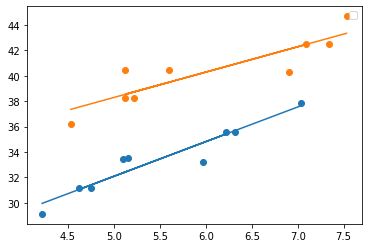

In [8]:
mos_longdress = np.array([4.21875, 4.75, 5.15625, 4.625, 5.96875, 6.21875, 5.09375, 6.3125, 7.03125])
mos_loot = np.array([4.53125, 5.21875, 5.59375, 5.125, 6.90625, 7.09375, 5.125, 7.34375, 7.53125])

plt.scatter(mos_longdress, video_psnr_color[videos[0]])
a, b = np.polyfit(mos_longdress, video_psnr_color[videos[0]], 1)
print(a, b)
plt.plot(mos_longdress, a*mos_longdress+b)

plt.scatter(mos_loot, video_psnr_color[videos[3]])
a, b = np.polyfit(mos_loot, video_psnr_color[videos[3]], 1)
print(a, b)
plt.plot(mos_loot, a*mos_loot+b)
plt.legend()

In [9]:
def linePlot(x, y, outputPath, title, legends, x_title, y_title):

    fig = plt.figure(figsize=(6, 4))

    i = 0
    for x_, y_ in zip(x,y):
        plt.scatter(x_, y_, label=legends[i])
        a, b = np.polyfit(x_, y_, 1)
        print(a, b)
        plt.plot(x_, a*x_+b)
        i += 1

    # plt.ylim(0,10)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.xlabel(x_title,fontsize=15)
    plt.ylabel(y_title,fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.savefig("{}/{}.pdf".format(outputPath, title))
    plt.show()

2.725754810906429 18.45839079311056
1.9936232756833814 28.319215252735663


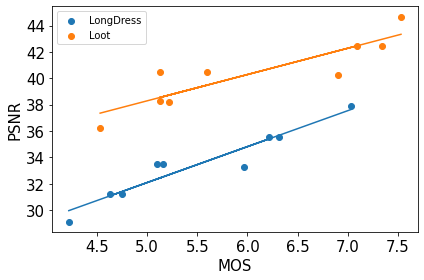

In [10]:
x = [mos_longdress, mos_loot]
y = [video_psnr_color[videos[0]], video_psnr_color[videos[3]]]

linePlot(x, y, "./figures", "PSNR_color",["LongDress", "Loot"], "MOS", "PSNR")

1.5809205805388555 7.331688995032665
1.3578569569141092 5.881806459009412


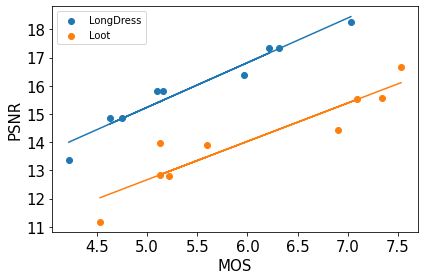

In [11]:
x = [mos_longdress, mos_loot]
y = [video_psnr_geometry[videos[0]], video_psnr_geometry[videos[3]]]

linePlot(x, y, "./figures", "PSNR_geometry",["LongDress", "Loot"], "MOS", "PSNR")

2.725754810906429 18.45839079311056
1.9936232756833814 28.319215252735663
2.808575026147809 19.621773383684193
2.2153038635895332 25.023505450945702


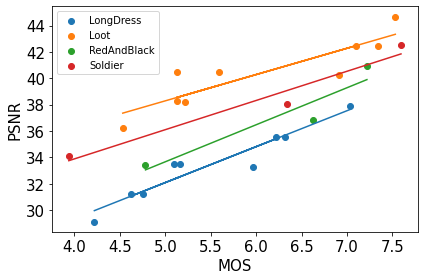

In [12]:
mos_redandblack = np.array([4.78125, 6.625, 7.21875]) # [q1, q2, q3]
mos_soldier = np.array([3.9375, 6.34375, 7.59375]) # [q1, q2, q3]

obj_soldier_color = np.array([34.106847769055555, 38.02213302155556, 42.54009212388889])
obj_redandblack_color = np.array([33.382281832944436, 36.86559818305556, 40.92714999705556])

x = [mos_longdress, mos_loot, mos_redandblack, mos_soldier]
y = [video_psnr_color[videos[0]], video_psnr_color[videos[3]], obj_redandblack_color, obj_soldier_color]

linePlot(x, y, "./figures", "PSNR_color_all",["LongDress", "Loot", "RedAndBlack", "Soldier"], "MOS", "PSNR")

2.725754810906429 18.45839079311056
1.9936232756833814 28.319215252735663
1.961914574353685 4.213300256331977
1.4101169591632268 4.814391516641337


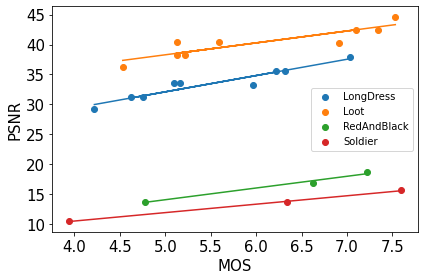

In [13]:
obj_soldier_geometry = np.array([10.416464747266668, 13.614338192366667, 15.618212255333335])
obj_redandblack_geometry = np.array([13.702710880000001, 16.763483676, 18.714365160333333])

x = [mos_longdress, mos_loot, mos_redandblack, mos_soldier]
y = [video_psnr_color[videos[0]], video_psnr_color[videos[3]], obj_redandblack_geometry, obj_soldier_geometry]

linePlot(x, y, "./figures", "PSNR_geometry_all",["LongDress", "Loot", "RedAndBlack", "Soldier"], "MOS", "PSNR")

## ML-based models

### Gradient boosting regressor

In [14]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [22]:
# load data
data = pd.read_csv('data.csv')
dataset = data.values
dataset

array([[32.  , 42.  , 32.  , ...,  5.  ,  4.64,  1.  ],
       [32.  , 42.  , 32.  , ...,  5.  ,  4.64,  6.  ],
       [32.  , 42.  , 32.  , ...,  5.  ,  4.64,  3.  ],
       ...,
       [16.  , 22.  , 16.  , ...,  5.  , 35.29,  7.  ],
       [16.  , 22.  , 16.  , ...,  5.  , 35.29,  8.  ],
       [16.  , 22.  , 16.  , ...,  5.  , 35.29,  6.  ]])

In [16]:
# split data to X and Y
X = dataset[:,0:6]
Y = dataset[:,6]

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [18]:
# evaluate the model
for k in np.arange(2, 15):
    model = GradientBoostingRegressor()
    cv = RepeatedKFold(n_splits=k, n_repeats=k, random_state=1)
    n_scores = cross_val_score(model, X, Y, scoring='r2', cv=cv, n_jobs=1, error_score='raise')
    print('k = %d -- Score: %.3f (%.3f)' % (k, np.mean(n_scores), np.std(n_scores)))

k = 2 -- Score: 0.368 (0.017)
k = 3 -- Score: 0.350 (0.054)
k = 4 -- Score: 0.345 (0.091)
k = 5 -- Score: 0.352 (0.113)
k = 6 -- Score: 0.355 (0.112)
k = 7 -- Score: 0.349 (0.128)
k = 8 -- Score: 0.345 (0.130)
k = 9 -- Score: 0.351 (0.128)
k = 10 -- Score: 0.344 (0.138)
k = 11 -- Score: 0.346 (0.146)
k = 12 -- Score: 0.342 (0.160)
k = 13 -- Score: 0.338 (0.174)
k = 14 -- Score: 0.334 (0.184)


In [19]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=0)


# Standardize the dataset
#
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


# gbr_params = {'n_estimators': 1000,
#           'max_depth': 3,
#           'min_samples_split': 5,
#           'learning_rate': 0.01,
#           'loss': 'ls'}
model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train_std, Y_train)
# Print Coefficient of determination R^2
#
print("Model Accuracy: {:.3f}".format(model_gbr.score(X_test_std, Y_test)))
#
# Create the mean squared error
#
mse = mean_squared_error(Y_test, model_gbr.predict(X_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.436
The mean squared error (MSE) on test set: 2.0065


# Regression models

## Get data

In [1]:
bitrates = {
    'longdress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
    'loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
    'redandblack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
    'soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
}
distance_map = {'d125': 1.25, 'd250': 2.5, 'd500': 5}
g_qp_map = {'r1': 32, 'r3': 24, 'r5': 16}
t_qp_map = {'r1': 42, 'r3': 32, 'r5': 22}

In [6]:
import pandas as pd
import numpy as np
# get input data
df = pd.read_csv('./results/ratings.csv')
df

,user,objects,qoe,time
0,19,Soldier_r3_r3_d500,7,2023-03-20-09:29:29+01:00
1,19,Soldier_r3_r3_d250,5,2023-03-20-09:29:47+01:00
2,19,RedAndBlack_r3_r3_d125,5,2023-03-20-09:30:01+01:00
3,19,Soldier_r5_r5_d250,7,2023-03-20-09:30:16+01:00
4,19,Soldier_r5_r5_d500,8,2023-03-20-09:30:30+01:00
...,...,...,...,...
1147,56,Loot_r3_r3_d500,6,2023-03-31-15:47:04+02:00
1148,56,LongDress_r1_r5_d500,5,2023-03-31-15:47:17+02:00
1149,56,Loot_r1_r5_d500,4,2023-03-31-15:47:34+02:00
1150,56,Loot_r3_r1_d500,4,2023-03-31-15:47:45+02:00


In [7]:
df[['object', 'start_quality', 'end_quality', 'distance']] = df.objects.str.split('_', expand=True)
df['object'] = df['object'].str.lower()
df['start_gqp'] = df['start_quality'].map(g_qp_map)
df['start_tqp'] = df['start_quality'].map(t_qp_map)
df['end_gqp'] = df['end_quality'].map(g_qp_map)
df['end_tqp'] = df['end_quality'].map(t_qp_map)
df['distance'] = df['distance'].map(distance_map)
df['bitrate'] = None
df


,user,objects,qoe,time,object,start_quality,end_quality,distance,start_gqp,start_tqp,end_gqp,end_tqp,bitrate
0,19,Soldier_r3_r3_d500,7,2023-03-20-09:29:29+01:00,soldier,r3,r3,5.00,24,32,24,32,None
1,19,Soldier_r3_r3_d250,5,2023-03-20-09:29:47+01:00,soldier,r3,r3,2.50,24,32,24,32,None
2,19,RedAndBlack_r3_r3_d125,5,2023-03-20-09:30:01+01:00,redandblack,r3,r3,1.25,24,32,24,32,None
3,19,Soldier_r5_r5_d250,7,2023-03-20-09:30:16+01:00,soldier,r5,r5,2.50,16,22,16,22,None
4,19,Soldier_r5_r5_d500,8,2023-03-20-09:30:30+01:00,soldier,r5,r5,5.00,16,22,16,22,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,56,Loot_r3_r3_d500,6,2023-03-31-15:47:04+02:00,loot,r3,r3,5.00,24,32,24,32,None
1148,56,LongDress_r1_r5_d500,5,2023-03-31-15:47:17+02:00,longdress,r1,r5,5.00,32,42,16,22,None
1149,56,Loot_r1_r5_d500,4,2023-03-31-15:47:34+02:00,loot,r1,r5,5.00,32,42,16,22,None
1150,56,Loot_r3_r1_d500,4,2023-03-31-15:47:45+02:00,loot,r3,r1,5.00,24,32,32,42,None


In [8]:
for row in np.arange(df.shape[0]):
    df['bitrate'][row] = (bitrates[df['object'][row]][df['start_quality'][row]] + bitrates[df['object'][row]][df['end_quality'][row]])/2

columns = ['start_gqp', 'start_tqp', 'end_gqp', 'end_tqp', 'distance', 'bitrate', 'qoe']
data = df[columns]
data

/var/folders/3b/q3j0_8jx1r16_v2mnl8r9w2w0000gn/T/ipykernel_60908/1205769127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bitrate'][row] = (bitrates[df['object'][row]][df['start_quality'][row]] + bitrates[df['object'][row]][df['end_quality'][row]])/2


,start_gqp,start_tqp,end_gqp,end_tqp,distance,bitrate,qoe
0,24,32,24,32,5.00,11.58,7
1,24,32,24,32,2.50,11.58,5
2,24,32,24,32,1.25,7.55,5
3,16,22,16,22,2.50,35.29,7
4,16,22,16,22,5.00,35.29,8
...,...,...,...,...,...,...,...
1147,24,32,24,32,5.00,5.63,6
1148,32,42,16,22,5.00,25.71,5
1149,32,42,16,22,5.00,9.48,4
1150,24,32,32,42,5.00,3.955,4


In [20]:
# remove outliers using boxplot method
vpcc_group_columns = ['start_gqp', 'start_tqp', 'end_gqp', 'end_tqp', 'distance', 'bitrate']
configurations = data.groupby(vpcc_group_columns)

def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25)["qoe"]
    q3 = frame.quantile(0.75)["qoe"]
    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    filterd = (frame["qoe"] >= fence_low) & (frame["qoe"] <= fence_high)
    return frame.loc[filterd]

# for each configuration, filter outliers
df_vpcc_filtered = None
for _, frame in configurations:
    #print(boxplot_outlier_filter(frame))
    df_vpcc_filtered = pd.concat([df_vpcc_filtered, boxplot_outlier_filter(frame)], axis=0)

df_vpcc_filtered = df_vpcc_filtered.reset_index(drop=True)
groups = df_vpcc_filtered.groupby(vpcc_group_columns)


In [21]:
# vpcc_group_columns = ["g-qp-s", "t-qp-s", "g-qp-e", "t-qp-e", "distance", "bitrate"]
# groups = data.groupby(vpcc_group_columns)

In [22]:
from sklearn import preprocessing

def get_train_test_fold(groups, test_group_name, normalize=False):
    """
    Get train/test folds for leave-one-out cross-validation. 

    :param test_group_name: the group name of the test fold
    :param normalize: normalize the data with StandardScaler
    :return: tuple with data frames (train features, train labels, test features, test labels)
    """
    # remove testing group
    training_group_keys = list(groups.groups.keys())
    training_group_keys.remove(test_group_name)
    training_groups = pd.concat(list(map(groups.get_group, training_group_keys)))
   
    y_train = training_groups['qoe']
    # The features must not contain the last column
    x_train = training_groups.drop('qoe', axis=1)

    # single test sample from test group
    y_test = groups.get_group(test_group_name)['qoe'].mean()
    x_test = groups.get_group(test_group_name).head(1).iloc[:,:-1]

    if normalize:
        scaler_x = preprocessing.StandardScaler().fit(x_train)
        x_train = scaler_x.transform(x_train)
        x_test = scaler_x.transform(x_test)

    return x_train, y_train, x_test, y_test

In [23]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (Ridge, Lasso,LinearRegression)
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import  MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error

seed = 117
report = None

regressor_models = [
    KNeighborsRegressor(leaf_size=10, n_neighbors=10),
    RandomForestRegressor(random_state=seed),
    Ridge(random_state=seed),
    Lasso(random_state=seed),
    GradientBoostingRegressor(random_state=seed),
    DecisionTreeRegressor(random_state=seed),
    MLPRegressor(random_state=seed),
    LinearRegression(),
    make_pipeline(PolynomialFeatures(2), preprocessing.StandardScaler(), LinearRegression())
]

for group_name in groups.groups.keys():
    x_train, y_train, x_test, y_test = get_train_test_fold(groups, group_name)

    for model in regressor_models:
        model.fit(x_train, y_train)

        # result is the MOS prediction
        mos_prediction = model.predict(x_test)
        
        results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
        results['test_configuration'] = str(group_name)
        results['model'] = model.__class__.__name__
        results['true_mos'] = y_test
        results['predicted_mos'] =float(mos_prediction) 
        results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

        report = pd.concat([report, results], axis=0, ignore_index=True)

report

/Users/minhkstn/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/minhkstn/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/minhkstn/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/minhkstn/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/minhk

,predicted_mos,test_configuration,model,true_mos,mse
0,6.000000,"(16, 22, 16, 22, 1.25, 22.9)",KNeighborsRegressor,6.187500,0.035156
1,4.896974,"(16, 22, 16, 22, 1.25, 22.9)",RandomForestRegressor,6.187500,1.665456
2,6.337357,"(16, 22, 16, 22, 1.25, 22.9)",Ridge,6.187500,0.022457
3,7.013606,"(16, 22, 16, 22, 1.25, 22.9)",Lasso,6.187500,0.682450
4,4.876319,"(16, 22, 16, 22, 1.25, 22.9)",GradientBoostingRegressor,6.187500,1.719195
...,...,...,...,...,...
319,4.036674,"(32, 42, 32, 42, 5.0, 4.64)",GradientBoostingRegressor,4.064516,0.000775
320,3.937500,"(32, 42, 32, 42, 5.0, 4.64)",DecisionTreeRegressor,4.064516,0.016133
321,5.133957,"(32, 42, 32, 42, 5.0, 4.64)",MLPRegressor,4.064516,1.143704
322,4.093750,"(32, 42, 32, 42, 5.0, 4.64)",LinearRegression,4.064516,0.000855


## Aggregate results

In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as R2
import math

model_performance = None

for model, group_content in report.groupby('model'):
    single_model_performance = pd.DataFrame(
        data=
        [[
            model,
            R2(group_content['true_mos'], group_content['predicted_mos']),
            mean_squared_error(group_content['true_mos'], group_content['predicted_mos']),
            math.sqrt(mean_squared_error(group_content['true_mos'], group_content['predicted_mos'])),
            mean_absolute_error(group_content['true_mos'], group_content['predicted_mos'])
        ]],
        columns=
        [
            "model",
            "r2_score",
            "mse",
            "rmse",
            "mae"
        ]
    )
    model_performance = pd.concat([model_performance, single_model_performance], axis=0, ignore_index=True)

model_performance = model_performance.sort_values(["r2_score", "mse", "mae"], ascending=False).reset_index(drop=True)
model_performance

,model,r2_score,mse,rmse,mae
0,GradientBoostingRegressor,0.858174,0.287361,0.536061,0.417536
1,Ridge,0.845453,0.313137,0.559586,0.470663
2,LinearRegression,0.842352,0.319420,0.565173,0.474135
3,RandomForestRegressor,0.838444,0.327338,0.572135,0.453489
4,DecisionTreeRegressor,0.795368,0.414616,0.643907,0.527169
5,Pipeline,0.768579,0.468896,0.684760,0.509714
6,Lasso,0.616035,0.777972,0.882027,0.694399
7,KNeighborsRegressor,0.514992,0.982701,0.991313,0.794128
8,MLPRegressor,0.305065,1.408047,1.186611,1.020398
